# Time Domain Science Cases in the Galactic Plane

The purpose of this notebook is to evaluate the science cases that require time domain observations.  Here I distinguish these cases from those requesting proper motion measurements, since they tend to be distinct in their observational requirements.  For the purposes of this analysis, time domain science is identifed as those cases which requested more than 3 visits per field pointing over the lifetime of the survey.  

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import config_utils
import survey_footprints
import regions
import healpy as hp
from mw_plot import MWSkyMap, MWSkyMapBokeh
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, TETE, SkyCoord, ICRS
from astropy.table import Table, Column
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
from os import path
%matplotlib inline


# Configure path to local repository
root_dir = '/Users/rstreet/software/rgps'

# HEALpixel grid resolution
NSIDE = 64
PIXAREA = hp.nside2pixarea(NSIDE, degrees=True)

First we load the simulation parameters for reference.

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

The requirements of all science cases proposed as White Papers and Science Pitches are described in the configuration file for this package:

In [3]:
science_cases = config_utils.read_config(path.join(root_dir, 'config', 'rgps_science_cases.json'))

Science cases requesting time domain observations are identifed in the configurations with a Boolean 'time_domain' key.  
So we can extract the information for just those cases for further analysis. 

In [4]:
time_domain_science = {author: info for author, info in science_cases.items() if info['time_domain']}
authors_list = [x for x in time_domain_science.keys()]
authors_list.sort()
print('Number of time domain science cases = ' + str(len(time_domain_science)))
print('\n')
print('Time domain authors and visit intervals [hrs] requested per region and filter:')
for author, params in time_domain_science.items():
    print(author + ': ')
    for optic in sim_config['OPTICAL_COMPONENTS']: 
        if optic in params.keys():
            for r in params[optic]:
                if 'l' in r.keys(): 
                    footprint = 'l: ' + repr(r['l']) + ', b:' + repr(r['b'])
                elif 'pointing' in r.keys():
                    footprint = 'pointing: ' + repr(r['pointing'])
                elif 'survey_footprint' in r.keys(): 
                    footprint = 'survey footprint: ' + r['survey_footprint'] 
                elif 'catalog' in r.keys():
                    footprint = 'catalog: ' + r['catalog']
                    
                print('  ' + optic + ' region=' + r['name'] + ' visit intervals=' + repr(r['visit_interval']) + ' footprint=' + footprint)

Number of time domain science cases = 15


Time domain authors and visit intervals [hrs] requested per region and filter:
Paladini2: 
  F213 region=Paladini_TDA visit intervals=[4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0] footprint=l: [25.0, 32.0], b:[2.0, 6.0]
Benecchi: 
  F146 region=Benecchi1 visit intervals=[2920.0] footprint=pointing: [17.43229895, -14.63082839, 0.52]
Kupfer: 
  F062 region=High_density1 visit intervals=[0.01] footprint=survey footprint: stellar_density
  F087 region=High_density1 visit intervals=[0.01] footprint=survey footprint: stellar_density
Lian: 
DAmmando: 
  F184 region=DAmmando_catalog visit intervals=[3.0] footprint=catalog: table-4LAC-DR3-l.fits
Freeman: 
  F158 region=RRLyrae1 visit intervals=[12.2] footprint=l: [-1, 1.0], b:[-3.0, 3.0]
  F158 region=RRLyrae2 visit intervals=[12.2] footprint=l: [89.0, 91.0], b:[-3.0, 3.0]
  F158 region=RRLyrae3 visit intervals=[12.2] footprint=l: [179.0, 181.0], b:[-3.0, 3.0]
  F158 region=RRLyrae4 visit intervals=[12.2] fo

## Sky Regions for Time Domain Surveys

It's informative to examine what regions of sky have been requested for time-domain surveys. To make this easier the regions for each science case have been pre-calculated, so we can load them all here, then select out those for time domain science.

In [5]:
science_regions = regions.load_regions_from_file(sim_config,
                                                         path.join(root_dir, 'config', 'rgps_science_regions.json'))

In [7]:
# Collect the regions for time domain science cases.  Note not all of them may be present; this 
# happens if a science case is marked not ready for use.  This is done if insufficient information has been provided by 
# an author.
time_domain_regions = {} 
for author in authors_list:
    if author in science_regions.keys():
        time_domain_regions[author] = science_regions[author]

In the interests of identifying regions that may have been requested by different authors for different filters, we will combine the regions across all passbands, including spectroscopic. 

Maximum HEALpixel value = 7.0


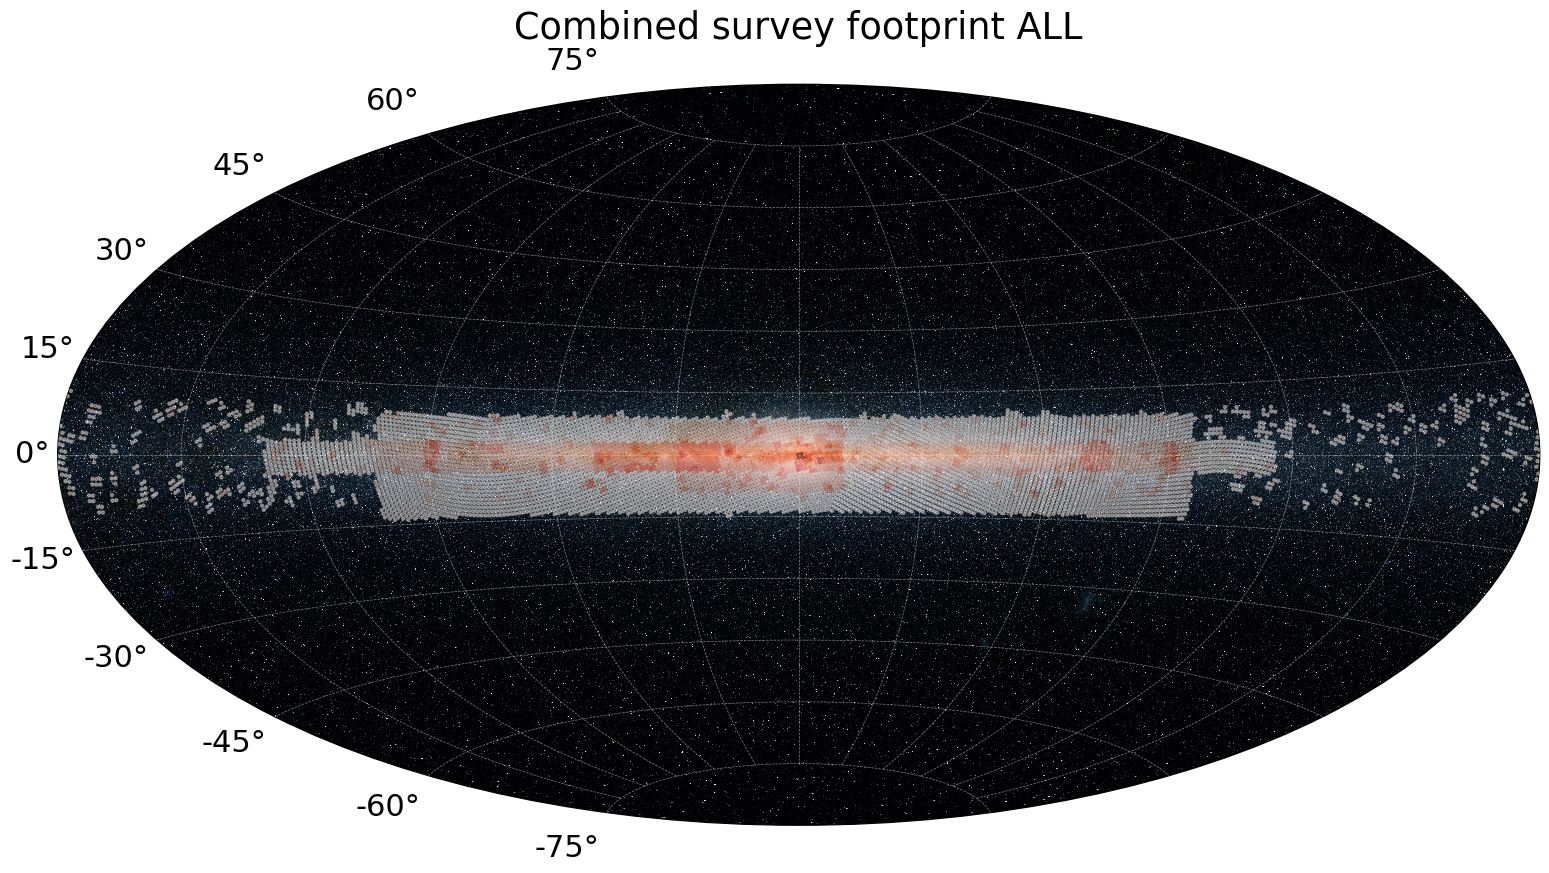

In [29]:
# Compile a list of regions for this optic over all science cases 
region_list = []
region_names = []

for optic in sim_config['OPTICAL_COMPONENTS']: 

    for author, params in time_domain_regions.items():
        if optic in params.keys():

            # Do not duplicate a region if an author has requested it for multiple filters
            for r in params[optic]:
                if r.name not in region_names:
                    region_list.append(r)
                    region_names.append(r.name)

if len(region_list) > 0:
    r_merge = regions.combine_regions(region_list)
    r_merge.optic = 'ALL'
    r_merge.label = 'Combined survey footprint'

    mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='infrared', figsize=(16, 10))
    mw1.title = r_merge.label + ' ' + r_merge.optic
    s = r_merge.pixels_to_skycoords()
    mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c=r_merge.region_map[r_merge.pixels], cmap='Reds', s=5, alpha=0.4)
    plt.rcParams.update({'font.size': 22})

    plt.tight_layout()
    plt.savefig(path.join(root_dir, 'time_domain_science', 'survey_map_all_passbands.png'))

print('Maximum HEALpixel value = ' + str(r_merge.region_map.max()))

## Priority regions for time domain science

We can now use this heatmap to identify regions of interest to multiple science cases from the HEALpixel values. 

To identify key regions of interest, we select HEALpixels requested by multiple science cases in multiple filters. 

N overlap science cases=5 N HEALpixels=33 area=27.7sq.deg.


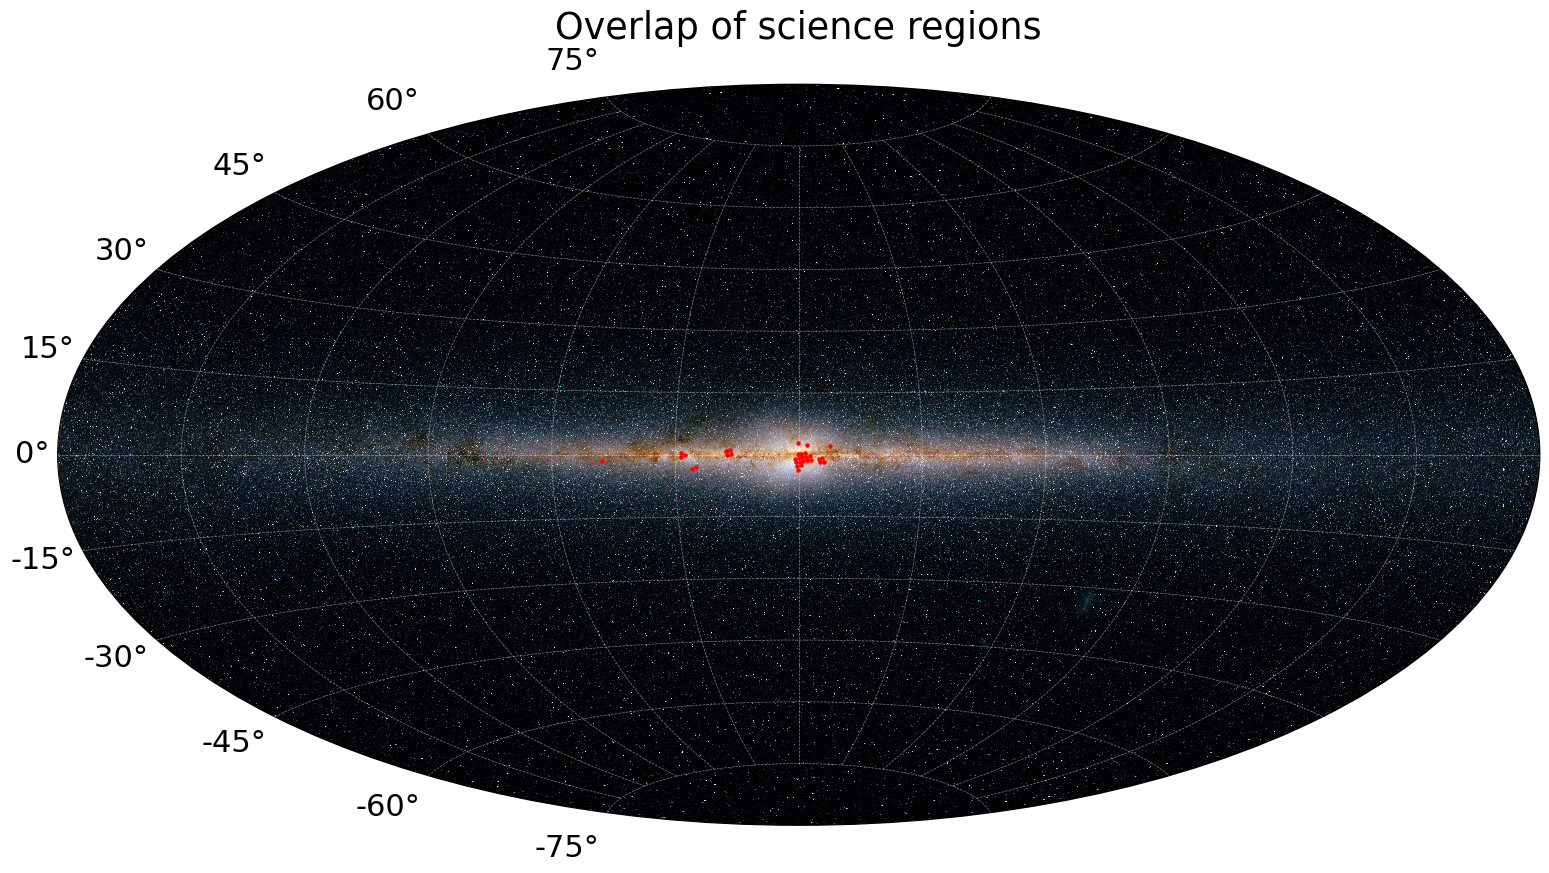

In [32]:
threshold = 5.0 # Number of science cases requesting a HEALpixel in any filter

pixels = np.where(r_merge.region_map >= threshold)[0]

candidate_regions = {'pixel_set': pixels}

area = len(pixels) * PIXAREA
print('N overlap science cases=' + str(int(threshold)) 
      + ' N HEALpixels=' + str(len(pixels)) + ' area=' + str(round(area,2)) + 'sq.deg.')

# Plot these regions 
mw1 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='infrared', figsize=(16, 10))
mw1.title = 'Overlap of science regions'
proj = HEALPix(nside=64, order='ring', frame='icrs')

s = proj.healpix_to_skycoord(pixels)
mw1.scatter(s.ra.deg * u.deg, s.dec.deg * u.deg, c='r', s=5, alpha=1.0)
plt.rcParams.update({'font.size': 22})

plt.tight_layout()
plt.savefig(path.join(root_dir, 'time_domain_science', 'tda_overlap_region_map_all_passbands.png'))


The candidate_regions entries per optic may have multiple clusters of HEALpixels, which need to be counted as separate regions.  

In [33]:
def get_lrange(llist):

    idx1 = np.where(llist > 180.0)[0] 
    idx2 = np.where(llist <= 180.0)[0] 

    l0 = llist[idx1].min() 
    l1 = llist[idx2].max() 

    return l0, l1

In [34]:
def cluster_pixels(params):
    
    # Convert the HEALpixels to a set of Skycoords in the galactic frame
    proj = HEALPix(nside=64, order='ring', frame='icrs')
    pixels = params['pixel_set']
    coords = proj.healpix_to_skycoord(pixels)
    coords = coords.transform_to('galactic')

    clusters = {}
    nc = -1
    max_sep = 2.5 * u.deg
    while len(coords) > 0:
        s = coords[0]
        
        sep = s.separation(coords)

        jdx = np.where(sep <= max_sep)[0]
        kdx = np.where(sep > max_sep)[0]
        
        l = coords[jdx].l.deg
        lmin = l.min() 
        lmax = l.max()
        print('RANGE: ',l, coords[jdx].b.deg)
        
        # Handle case if the region straddles the l-coordinate rollover
        if lmin > 0.0 and lmin < 180.0 and lmax > 180.0: 
            l0,l1 = get_lrange(l)
        else:
            l0 = l.min()
            l1 = l.max() 
        b0 = coords[jdx].b.deg.min()
        b1 = coords[jdx].b.deg.max()
        print('CORNERS: ', lmin, lmax, l0, l1, b0, b1)
        
        # Calculate the centroid as the mid-point of the diagonal between 
        # the opposing corners of a box encompasing the all HEALpixels in the region
        corner1 = SkyCoord(l0, b0, frame='galactic', unit=(u.deg, u.deg))
        corner2 = SkyCoord(l1, b1, frame='galactic', unit=(u.deg, u.deg))
        pa = corner1.position_angle(corner2)
        sep = corner1.separation(corner2)
        center = corner1.directional_offset_by(pa, sep/2)  
        
        cluster = { 
            'l_center': center.l.deg,
            'b_center': center.b.deg,
            'l0': l0,
            'l1': l1,
            'b0': b0,
            'b1': b1,
            'pixels': pixels[jdx]
        }
        nc += 1 
        
        clusters[nc] = cluster

        # Remove identified pixels from the coords list 
        coords = coords[kdx]
        pixels = pixels[kdx]
        
    params['clusters'] = clusters

    return params

In [35]:
region_set = {}
params = cluster_pixels(candidate_regions)

# Filter out clusters that are unfeasibly large
for key, value in params.items():
    if key == 'clusters':
        subset = {}
        for cid,cluster in params['clusters'].items():
            #dl = abs(cluster['l0'] - cluster['l1'])
            #if len(cluster['pixels']) < 20.0 and dl < 20.0:
            print(' -> ', cid, cluster)
            subset[cid] = cluster
        params['clusters'] = subset
    else:
        print(key, value)
    
candidate_regions = params


RANGE:  [47.91229496] [-1.41141797]
CORNERS:  47.9122949637777 47.9122949637777 47.9122949637777 47.9122949637777 -1.4114179705061947 -1.4114179705061947
RANGE:  [28.68873622 28.47723108 27.62438852] [ 0.42073947 -0.47660733 -0.12668925]
CORNERS:  27.624388519213877 28.68873621744346 27.624388519213877 28.68873621744346 -0.4766073328462903 0.42073947105053183
RANGE:  [25.90521394 25.05097293] [-3.36061138 -3.01343688]
CORNERS:  25.050972925067917 25.90521393542949 25.050972925067917 25.90521393542949 -3.3606113821515726 -3.013436882265577
RANGE:  [17.54838754 16.68386658 17.32857727 16.46451429] [ 0.86723104  1.17864798 -0.02485863  0.28670412]
CORNERS:  16.46451428632521 17.54838753953173 16.46451428632521 17.54838753953173 -0.02485862587382556 1.1786479806636059
RANGE:  [1.24813295e-01 3.58078949e+02] [2.92223956 2.33744993]
CORNERS:  0.124813294965907 358.07894921214194 358.07894921214194 0.124813294965907 2.3374499262042425 2.9222395561923715
RANGE:  [2.96775421e-01 9.33014424e-01 

In [37]:
# Pixel clusters are separated by assuming they have to be a maximum angular separation apart
max_sep = 2.5*u.deg
optic_col = []
data = np.array([])
ids = []
centroids = np.array([])
for cid,cluster in candidate_regions['clusters'].items():
    print('Cluster ', cid)
    s = SkyCoord(cluster['l_center'], cluster['b_center'], frame='galactic', unit=(u.deg, u.deg))

    # Check whether we already have a region at this location 
    if len(centroids) > 0: 
        cluster_centroids = SkyCoord(centroids[:,0], centroids[:,1], frame='galactic', unit=(u.deg, u.deg))
        sep = s.separation(cluster_centroids) 
        
        # If not, then add a new cluster
        if (sep >= max_sep).all():                
            ids.append(len(ids))
            data = np.vstack((data,[
                cluster['l_center'], cluster['b_center'], 
                cluster['l0'], cluster['l1'], cluster['b0'], cluster['b1']
            ]))

            optic_col.append(optic)

            centroids = np.vstack((centroids, [cluster['l_center'], cluster['b_center']]))
            print('Added new row') 
            
        # If the cluster is already known, compare the boundaries and extend if need be to  
        # form the cluster superset of pixels.  Also add the optic to the list of optics requesting 
        # this cluster
        else:
            #print('Existing clusters: ', cluster_centroids)
            #print('Candiddate cluster ',s)
            
            #print('Separations: ',sep, max_sep)
            
            cid = np.where(sep <= max_sep)[0][0]
            if len(data.shape) == 1: 
                cmatch = data
            else:
                cmatch = data[cid,:]
            superset = False 
            if superset:
                print('Extending boundaries')
                cmatch[2] = min(cmatch[2], cluster['l0']) 
                cmatch[3] = max(cmatch[3], cluster['l1']) 
                cmatch[4] = min(cmatch[4], cluster['b0']) 
                cmatch[5] = max(cmatch[5], cluster['b1'])
                cmatch[0] = np.median([cmatch[2],cmatch[3]])
                cmatch[1] = np.median([cmatch[4],cmatch[5]])
                if len(data.shape) == 1:
                    data = cmatch
                else:
                    data[cid,:] = cmatch
            if optic not in optic_col[cid]:
                optic_col[cid] = optic_col[cid] + ', ' + optic
            print('Found matching row') 
            
    # If we have no clusters yet, simply add a new one 
    else:
        ids.append(len(ids))
        data = np.array([
            cluster['l_center'], cluster['b_center'], 
            cluster['l0'], cluster['l1'], cluster['b0'], cluster['b1']
        ])
        optic_col.append(optic)

        centroids = np.array([[cluster['l_center'], cluster['b_center']]])
        print('Added first row')
                
data = np.array(data)

# Allow for testing with a single filter
if len(data.shape) == 1:
    TD_regions = Table([
        Column(name='ID', data=ids),
        Column(name='l_center', data=[data[0]]),
        Column(name='b_center', data=[data[1]]),
        Column(name='l0', data=[data[2]]),
        Column(name='l1', data=[data[3]]),
        Column(name='b0', data=[data[4]]),
        Column(name='b1', data=[data[5]])
    ])

else:
    TD_regions = Table([
        Column(name='ID', data=ids),
        Column(name='l_center', data=data[:,0]),
        Column(name='b_center', data=data[:,1]),
        Column(name='l0', data=data[:,2]),
        Column(name='l1', data=data[:,3]),
        Column(name='b0', data=data[:,4]),
        Column(name='b1', data=data[:,5])
    ])

TD_regions

Cluster  0
Added first row
Cluster  1
Added new row
Cluster  2
Added new row
Cluster  3
Added new row
Cluster  4
Added new row
Cluster  5
Added new row
Cluster  6
Found matching row
Cluster  7
Added new row
Cluster  8
Added new row
Cluster  9
Found matching row


<Table length=8>
  ID       l_center      ...          b0                   b1        
int64      float64       ...       float64              float64      
----- ------------------ ... -------------------- -------------------
    0   47.9122949637777 ...  -1.4114179705061947 -1.4114179705061947
    1 28.156564400180546 ...  -0.4766073328462903 0.42073947105053183
    2  25.47816548554969 ...  -3.3606113821515726  -3.013436882265577
    3  17.00639359877919 ... -0.02485862587382556  1.1786479806636059
    4  359.1016414495964 ...   2.3374499262042425  2.9222395561923715
    5  359.5772949531017 ...  -1.8345263422767624 0.42311008236978526
    6  356.5711151496666 ...  -1.3351448959821877 -0.3137698775509586
    7 352.32986383164575 ...    2.052841252322848   2.052841252322848

Plot these selected regions for easy reference.

In [38]:
def plot_outline(skymapplot, survey_region, ssmall=5.0):
    """
    Function to plot the outline of a survey footprint, given the survey region boundaries in the form of 
    survey_region = { 'l': [lmin, lmax], 'b': [bmin, bmax] }
    """

    l0 = survey_region['l'][0]
    l1 = survey_region['l'][1]
    if l0 > 0.0 and l0 > 180.0 and l1 < 180.0: 
        lrangeset = [np.arange(l0, 359.9, 0.1), np.arange(0.0, l1, 0.1)]
        brangeset = [
            np.arange(survey_region['b'][0], survey_region['b'][1], 0.1), 
            np.arange(survey_region['b'][0], survey_region['b'][1], 0.1), 
        ]
    else:
        lrangeset = [np.arange(l0, l1, 0.1)]
        brangeset = [np.arange(survey_region['b'][0], survey_region['b'][1], 0.1)]
    
    # Plot a boundary region if lrange or brange has non-zero length: 
    for xx in range(0, len(lrangeset), 1): 
        lrange = lrangeset[xx]
        brange = brangeset[xx]
        
        if len(lrange) > 0 and len(brange) > 0:
            # Since the plotting package supports only scatter plots, calculate a range of points 
            # to represent the outer boundaries.  
            llist = []
            blist = []
        
            # Right-hand edge of box
            llist += [survey_region['l'][0]]*len(brange)
            blist += brange.tolist()
        
            # Left-hand edge of box 
            llist += [survey_region['l'][1]]*len(brange)
            blist += brange.tolist()
        
            # Lower edge of box 
            llist += lrange.tolist()
            blist += [survey_region['b'][0]]*len(lrange)
        
            # Upper edge of box 
            llist += lrange.tolist()
            blist += [survey_region['b'][1]]*len(lrange)
    
            alpha = 0.4
            
        # Otherwise, this is a single-point region, so plot it as such
        else:
            llist = [survey_region['l'][0]]
            blist = [survey_region['b'][0]]
            alpha = 1.0
            
        # Add this outline to the plot; this has to be done in ICRS coordinates
        s = SkyCoord(llist, blist, frame='galactic', unit=(u.deg, u.deg))
        s = s.transform_to(ICRS)
        skymapplot.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c='red', s=ssmall, alpha=alpha)

    return skymapplot

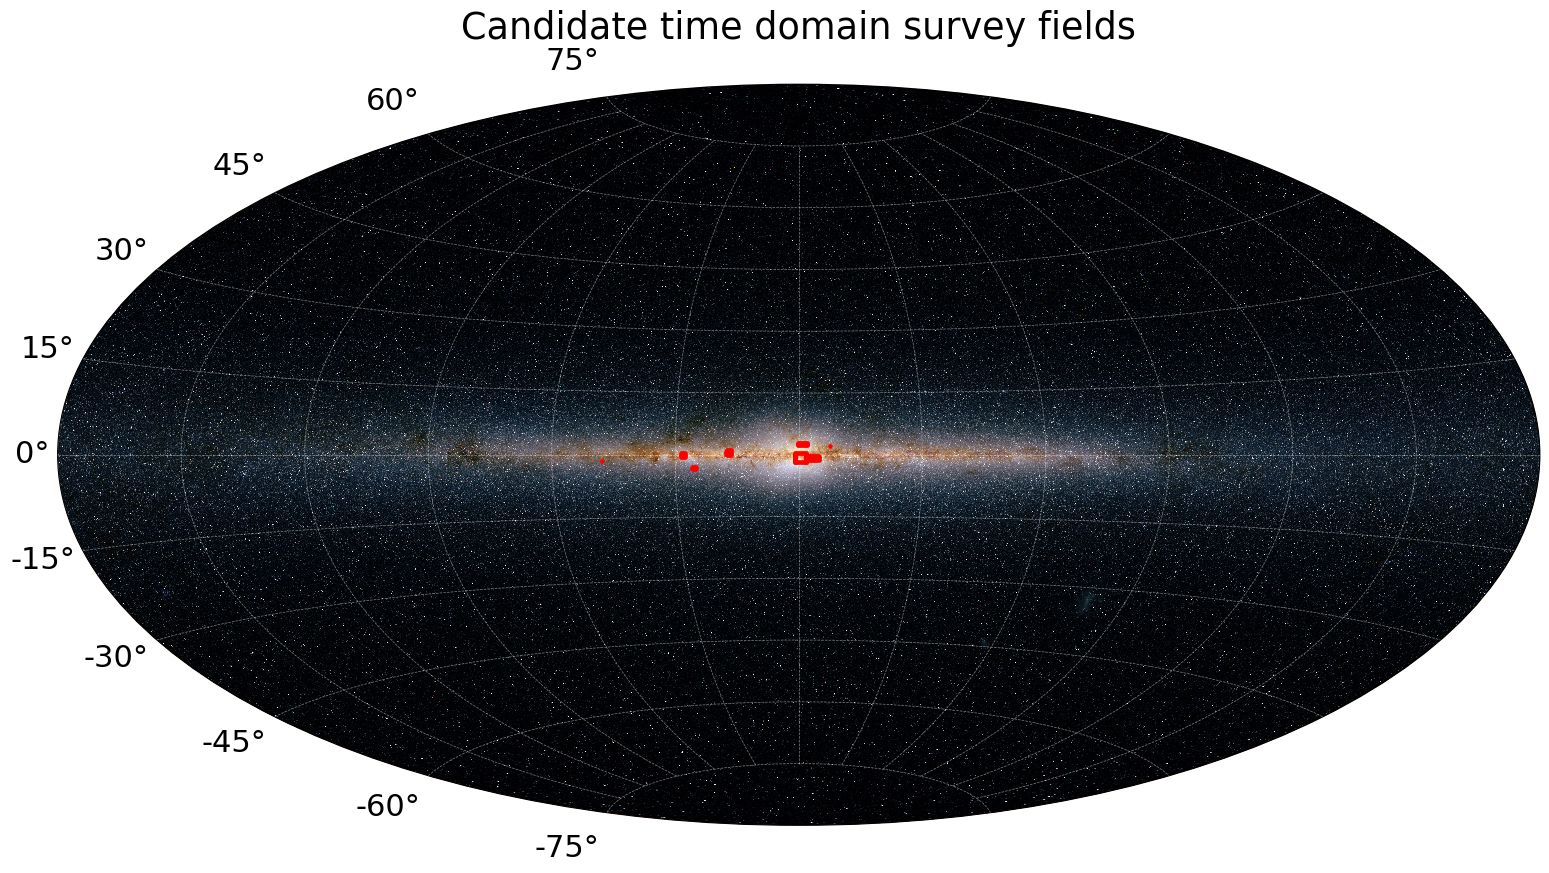

In [39]:
# Plot the selected TDA regions 
mw2 = MWSkyMap(projection='aitoff', grayscale=False, grid='galactic', background='infrared', figsize=(16, 10))
mw2.title = 'Candidate time domain survey fields'
proj = HEALPix(nside=64, order='ring', frame='icrs')

for r in TD_regions:
    outline = {
        'l': [float(r['l0']), float(r['l1'])],
        'b': [float(r['b0']), float(r['b1'])]
    }
    #print(outline)
    plot_outline(mw2, outline)

plt.rcParams.update({'font.size': 22})

plt.tight_layout()
plt.savefig(path.join(root_dir, 'time_domain_science', 'candidate_tda_fields.png'))
